### Common Functions

In [104]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from tensorflow.keras.datasets import mnist
from matplotlib.patches import Ellipse

# creates XY_table out of img and only takes koordinates where the pixle value is bigger than 0
# the table consists of [x, y] where x is the column in the img array and y is the row in the img array (when seen in data viewer)
def create_XY_table(img):
    result = []
    for i in range(28):
        for j in range(28):
            if(img[i][j] > 0):
                result.append([j, i])
    return np.array(result)

# It creates an XY_table for all the imgs in the input array. Then it returns a Big table with all the Koordinates of all the arrays
def create_XY_table_for_imgs(imgs):
    if len(imgs) == 0:
        return np.array([])
    
    result = create_XY_table(imgs[0])
    for img in imgs[1:]:
        XY_table = create_XY_table(img)
        result = np.concatenate((result, XY_table), axis=0)
    return np.array(result)

def plot_gmm(gmm, ax, color='blue'):
    for i in range(gmm.n_components):
        mean = gmm.means_[i]
        cov = gmm.covariances_[i]

        v, w = np.linalg.eigh(cov)
        v = 2. * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])

        angle = np.degrees(np.arctan2(u[1], u[0]))
        ell = Ellipse(xy=mean, width=v[0], height=v[1], angle=angle, edgecolor=color, facecolor='none', lw=2)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.6)
        ax.add_patch(ell)

def sub_plot_gmm_probabilities_in_subplot(fig, ax, train_data, fitted_gmms):
    XY_grid, X_grid, Y_grid = generate_mesh_grid(train_data)
    log_likelihoods_grid = np.array([gmm.score_samples(XY_grid) for gmm in fitted_gmms])
    average_log_likelihood_grid = np.mean(log_likelihoods_grid, axis=0)
    averaged_probabilities_grid = np.exp(average_log_likelihood_grid).reshape(X_grid.shape)

    prob_min = np.min(averaged_probabilities_grid)
    prob_max = np.max(averaged_probabilities_grid)
    normalized_probabilities_grid = (averaged_probabilities_grid - prob_min) / (prob_max - prob_min)

    contour = ax.contourf(X_grid, Y_grid, averaged_probabilities_grid, levels=20, cmap='viridis')
    fig.colorbar(contour)
    #ax.scatter(train_data[:, 0], train_data[:, 1], s=40, marker='H', edgecolor='k', c='g')
    ax.invert_yaxis()
    return XY_grid

def generate_mesh_grid(train_data):
    x = np.linspace(train_data[:, 0].min() - 1, train_data[:, 0].max() + 1, 100)
    y = np.linspace(train_data[:, 1].max() + 1, train_data[:, 1].min() - 1, 100)
    X_grid, Y_grid = np.meshgrid(x, y)
    XY_grid = np.array([X_grid.ravel(), Y_grid.ravel()]).T
    return XY_grid, X_grid, Y_grid

# overlays all the digits in the input array over another and averages all the points in the digit 2D array
def overlay_mnistdigits(digit_imgs):
    result = np.zeros((28,28))
    for i in range(28):
        for j in range(28):
            total_pixle_value = 0
            for digit in digit_imgs:
                total_pixle_value = total_pixle_value + digit[i][j]
            result[i][j] = round(total_pixle_value/len(digit_imgs))
    return result

def convert_pixel_to_probabilities(digit_img):
    result = np.zeros((28,28))
    for i in range(28):
        for j in range(28):
            result[i][j] = digit_img[i][j]/255
    return result

### IMPORTANT XY_table must be from img
def compare_error_of_GMM_and_IMG(fitted_gmms, xy_table, img):
    img_with_probs = convert_pixel_to_probabilities(img)
    log_likelihoods = np.array([gmm.score_samples(xy_table) for gmm in fitted_gmms])
    average_log_likelihoods = np.mean(log_likelihoods, axis=0)
    densities = np.exp(average_log_likelihoods)

    densities_min = np.min(densities)
    densities_max = np.max(densities)
    predictions = (densities - densities_min) / (densities_max - densities_min)

    error_map = np.zeros_like(img_with_probs)
    if len(xy_table) != len(predictions):
        raise ValueError(f"xy_table has to have the same length as the predictions array")
    for coord, prediction in zip(xy_table, predictions):
        error_per_pixel = (img_with_probs[coord[1]][coord[0]] - prediction)**2
        if(error_per_pixel >= 1 or error_per_pixel <= 0):
            print(f'error per pixel is out of range!! "{error_per_pixel}"')
        error_map[coord[1]][coord[0]] = error_per_pixel
        total_error = np.sum(error_map)
    return total_error, error_map

def compare_error_of_IMG_and_IMG(img1, img2):
    img1_probs = convert_pixel_to_probabilities(img1)
    img2_probs = convert_pixel_to_probabilities(img2)

    total_error = 0
    for i in range(28):
        for j in range(28):
            total_error += (img1_probs[i][j] - img2_probs[i][j])**2
    return total_error

### EXPERIMENTS ###
def experiment_1(single_digit_img, overlayed_digits, gmm_components):
    error_between_img_and_img = compare_error_of_IMG_and_IMG(overlayed_digits, single_digit_img)

    XY_table = create_XY_table(single_digit_img)
    gmm_01 = GaussianMixture(n_components=gmm_components, covariance_type='full')
    gmm_01.fit(XY_table)

    error_between_img_and_gmm, error_map = compare_error_of_GMM_and_IMG([gmm_01], XY_table, overlayed_digits)
    return [error_between_img_and_img, error_between_img_and_gmm]

### Common Variables

In [105]:
# Step 1: Load and preprocess MNIST data
(X_train, Y_train), (_, _) = mnist.load_data()  # X_train are the images of numbers represented in 2D arrays and Y_train is an array of numbers representing the lables of on the images

digit = 8
X_digit = X_train[Y_train == digit]
X_digit_img = X_digit[36]

overlayed_digits = overlay_mnistdigits(X_digit[:400])

### Check Error Calculation

error between overlayed img and gmm trained on single img is: "47.66553275411107"


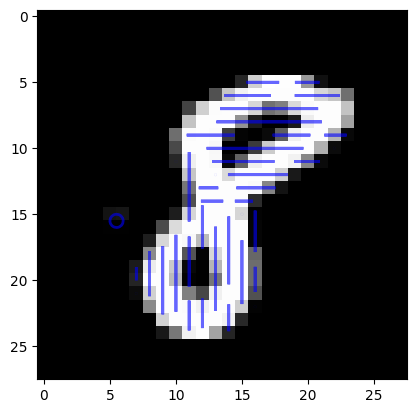

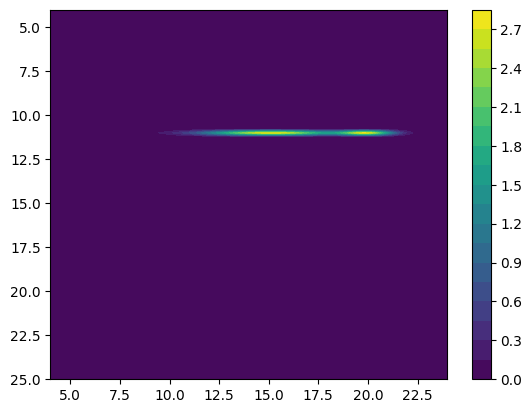

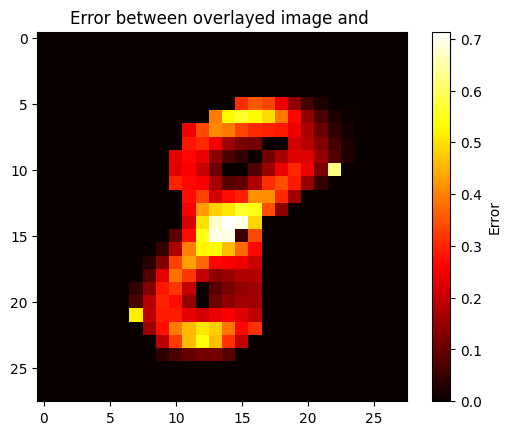

In [106]:
#compare_error_of_GMM_and_IMG()

test_img  = X_digit[70]

error_between_img_and_img = compare_error_of_IMG_and_IMG(overlayed_digits, test_img)

XY_table = create_XY_table(test_img)
gmm_01 = GaussianMixture(n_components=40, covariance_type='full', reg_covar=1e-6, max_iter=200)
gmm_01.fit(XY_table)

error_between_img_and_gmm, error_map = compare_error_of_GMM_and_IMG([gmm_01], XY_table, overlayed_digits)
print(f'error between overlayed img and gmm trained on single img is: "{error_between_img_and_gmm}"')

fig, ax = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()

plot_gmm(gmm_01, ax)

sub_plot_gmm_probabilities_in_subplot(fig2, ax2, XY_table, [gmm_01])

ax.imshow(test_img, cmap='gray')

im_error = ax3.imshow(error_map, cmap='hot')
ax3.set_title("Error between overlayed image and ")
cbar = fig3.colorbar(im_error, ax=ax3, orientation='vertical')
cbar.set_label("Error")
plt.show()

error per pixel is out of range!! "1.0"
EXPERIMENT 2
The error between the img and one GMM is "16.354855434049526"
The error between the img and ensemble of GMMs is "14.896885154332987"



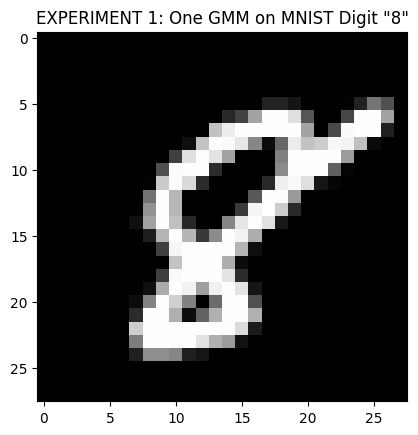

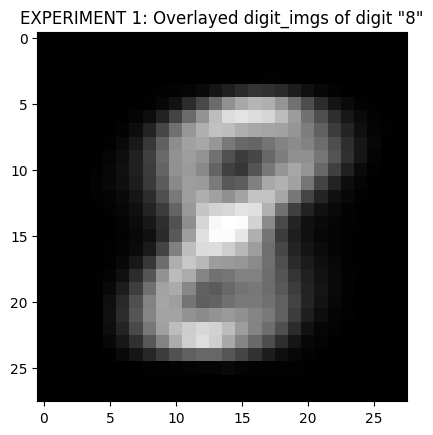

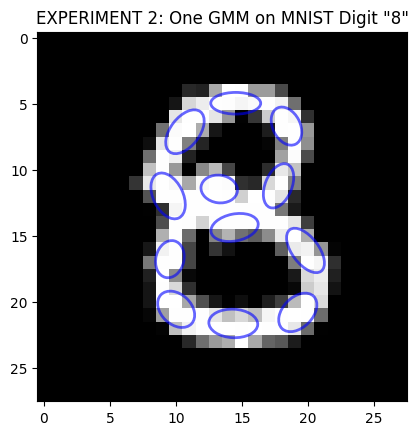

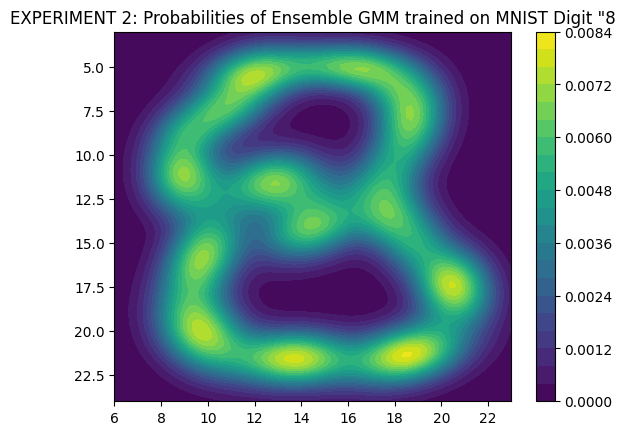

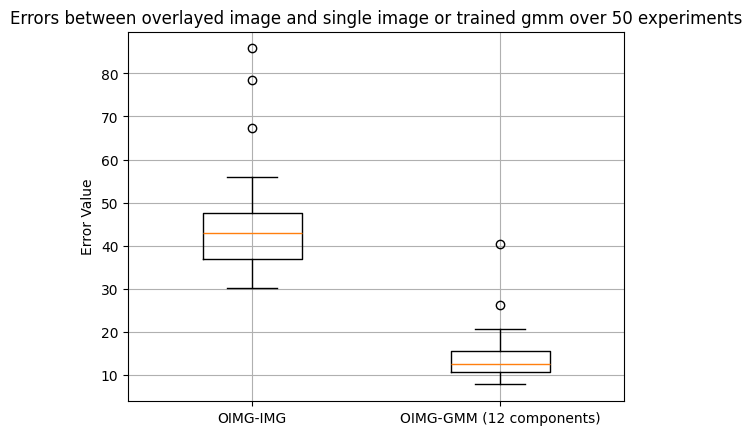

In [107]:

result_1 = []
gmm_component_number = np.random.randint(7, 20, 50)
for img, component_number in zip(X_digit[20:70], gmm_component_number):
    result_1.append(experiment_1(img, overlayed_digits, component_number))
result_1 = np.array(result_1)


### Experiment 2
digit_img_2 = X_digit[26]
XY_table_2 = create_XY_table(digit_img_2)

gmm2 = GaussianMixture(n_components=12, covariance_type='full')
gmm2.fit(XY_table_2)

gmm_array = [GaussianMixture(n_components=12, covariance_type='full') for _ in range(5)]

for one_gmm in gmm_array:
    one_gmm.fit(XY_table_2)

err_img_gmm, error_map_1 = compare_error_of_GMM_and_IMG([gmm2], XY_table_2, digit_img_2)
err_img_gmm_2, error_map_2 = compare_error_of_GMM_and_IMG(gmm_array, XY_table_2, digit_img_2)

print("EXPERIMENT 2")
print(f'The error between the img and one GMM is "{err_img_gmm}"')
print(f'The error between the img and ensemble of GMMs is "{err_img_gmm_2}"')
print()

fig, ax = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
fig4, ax4 = plt.subplots()
fig5, ax5 = plt.subplots()

positions = [1,2]
data = [result_1[:, 0], result_1[:, 1]]
ax5.boxplot(data, positions=positions, widths=0.4)
ax5.set_ylabel('Error Value')
ax5.grid(True)

ax5.set_xticks(positions) 
ax5.set_xticklabels(['OIMG-IMG', 'OIMG-GMM (12 components)'])
ax5.set_title("Errors between overlayed image and single image or trained gmm over 50 experiments")

plot_gmm(gmm2, ax3)

ax.imshow(X_digit_img, cmap='gray')
ax.set_title(f'EXPERIMENT 1: One GMM on MNIST Digit "{digit}"')
#sub_plot_gmm_probabilities_in_subplot(fig5, ax5, XY_table, [gmm_01])

ax2.imshow(overlayed_digits, cmap='gray')
ax2.set_title(f'EXPERIMENT 1: Overlayed digit_imgs of digit "{digit}"')

ax3.imshow(digit_img_2, cmap='gray')
ax3.set_title(f'EXPERIMENT 2: One GMM on MNIST Digit "{digit}"')

ax4.set_title(f'EXPERIMENT 2: Probabilities of Ensemble GMM trained on MNIST Digit "{digit}')
sub_plot_gmm_probabilities_in_subplot(fig4, ax4, XY_table_2, gmm_array)

plt.show()

## Boxplot of performance of GMMs depending on components
- Here 50 GMMs for each number of components is trained on 50 images out of the overlayed images
- Then it is compared which component number works best for the gmms and produces the lowest error
- the chosen component numbers are [9, 12, 20, 30, 40]

error per pixel is out of range!! "0.0"
error per pixel is out of range!! "0.0"
error per pixel is out of range!! "0.0"
error per pixel is out of range!! "1.0"
error per pixel is out of range!! "1.0"
error per pixel is out of range!! "1.0"


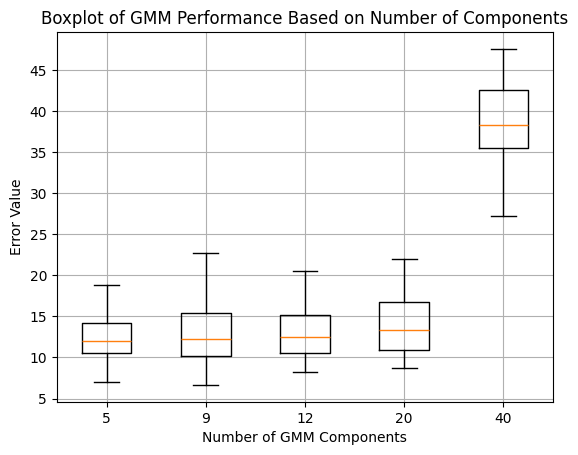

In [103]:
def experiment_1_2(single_digit_img, overlayed_digits, gmm_components):
    XY_table = create_XY_table(single_digit_img)
    gmm_01 = GaussianMixture(n_components=gmm_components, covariance_type='full')
    gmm_01.fit(XY_table)

    error_between_img_and_gmm, error_map = compare_error_of_GMM_and_IMG([gmm_01], XY_table, overlayed_digits)
    return error_between_img_and_gmm

gmm_comp_numbers = np.array([1, 9, 12, 20, 40])

result = []

for component_number in gmm_comp_numbers:
    zwischen_result = []
    for img in X_digit[20:70]:
        zwischen_result.append(experiment_1_2(img, overlayed_digits, component_number))
    result.append(np.array(zwischen_result))

plt.boxplot(result, tick_labels=gmm_comp_numbers, showfliers=False)
plt.title('Boxplot of GMM Performance Based on Number of Components')
plt.xlabel('Number of GMM Components')
plt.ylabel('Error Value')
plt.grid(True)
#plt.yscale('log')
plt.show()